<a href="https://colab.research.google.com/github/razzkoirala/devops-camp-pipeline/blob/main/LabDocument/5_Deploy_to_EKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deploy to EKS

Updated 5/5/2022

## Overview
In this lab, students will learn how to integrate EKS with Harbor and Jenkins to deploy their application as a running service.

**Estimated time:** 1 hr




## Learning Objectives

1. Setup command line tools  

2. Write the secret YAML file  

3. Write the deployment YAML files  

4. Write the service YAML files  

5. Create the deployments  

6. Validate application post-deployment in EKS

7. Update the Jenkins pipeline


# Instructions



## Initial Setup

1. Open VSCode and enter the lab environment you created in the containerization lab.

2. In the integrated terminal, run the following command to enter your aws credentials:
```
aws configure
```

 > **Note:** AWS credentials will be given to you. For "Default output format" just hit enter.

3.	Update kubectl to point to the EKS cluster you’ll be working with by running:
```
aws eks update-kubeconfig --name DevSecOps-Labs-Cluster
```

4.	Create the namespace in kubernetes that you’ll be working in for the remainder of this lab by running:
```
kubectl create namespace <FIRST NAME INITIAL + LAST NAME>
``` 

 > **Note:** You can verify your namespace creation by running: 
 ```
 kubectl get namespace
 ```

## Write the Secret YAML File

1.	In the VSCode "Explorer" pane on the left, find and open the `secrets.yaml` file in your `afs-labs-student/kubernetes` folder 

 > **Note:** Secrets in Kubernetes contain values for use in your applications that should not be stored in plaintext, in this application they represent login information to the app’s database

2.	Change the value after `name:` to `db-secret`
3.	Change the value after `namespace:` to your namespace that you created earlier (first initial + lastname).

 > **Note:** The key-value pairs under `data:` are used to access the database. The values are encoded in base64, but in plaintext they are "postgres," "admin1," and "shop," respectively.

4. Save your changes

## Write the Deployment YAML Files

1.	In the same `kubernetes` folder as above, make a copy of `app-deployment.yaml`and name it `db-deployment.yaml`. We'll focus on **`app-deployment.yaml`** first
  

2. Open the `app-deployment.yaml` file

 >**Note:** Deployments are used to control how many pods (containers) are ran for a specified image – for this app you will only need one pod (i.e., replica) for each image.

3.	Update the following fields: `name`, `app`, `namespace`, `replicas`, `image`, and `containerPorts`

 a.	Set both `name:` fields to `app-deployment`

  >**Tip:** There is a `name` field under the header `secretRef` that is already filled in with "db-secret," you can leave this as is since it is referencing the `secrets.yaml` file we just edited.
  
 b.	Set all `app:` fields to `app`

 c.	Set `namespace:` to your namespace

 d.	Set `replicas:` to `1 `
  
 e.	Set `image:` to the URL for your app’s harbor image
  
   <ul> i.	To find your image URL, go into your Harbor project, select your <code>/app</code> repository, then select the most recent artifact

  ii.	Your screen should look something like the image below:

  </ul>


<ul>
<figure>
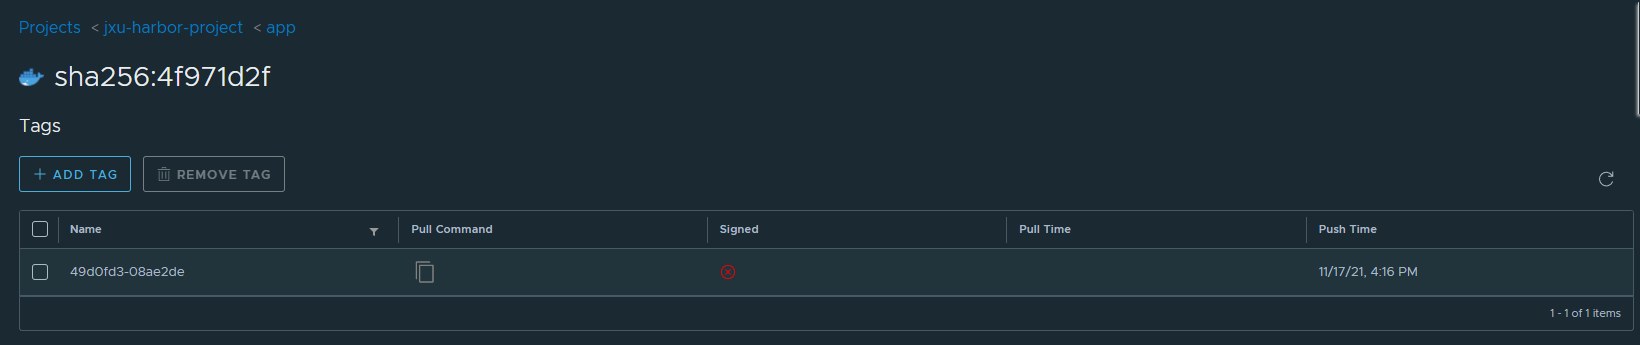
</figure>
</ul>

<ul> <ul>
 iii.	Click the copy button under the "Pull Command" column for your most recent image

 iv.	When you paste, remove “docker pull” from the pasted content
</ul> </ul>

<ul>

>**Tip:** If your image URL has "sha256:" in it, you've copied the wrong one. You'll need to click on the most recent object, then copy and paste the URL into your document.

f. Set `containerPort:` to `5000` 

g. Save your changes

</ul>


<ul>

 > **Explanation of relevant code snippets:**
>
>```
 - envFrom:
     - secretRef:
         name: db-secret
```
> This adds the environment variables from the `secrets.yaml` file you edited earlier.
>
>```
  strategy:
    type: Recreate
  minReadySeconds: 20
```
>
 >  
 > This is an update strategy and readiness delay, which define how the deployment is updated when a new image is deployed. For now, the strategy is set to `Recreate`, which will delete all the old pods and start them back up with the updated image
>
> The `minReadySeconds` are set to 20 so you should be able to see the pods being updated

</ul>

4.	Now we'll edit **`db-deployment.yaml`**. Update `db-deployment.yaml` in the following fields: `name`, `namespace`, `app`, `image`, and `containerPorts`

 a.	Set both `name:` fields to `db-deployment`

 b. Set `namespace:` to your namespace

 c.	Set all `app:` fields to `db`

 d. Set `replicas:` to `1 `

 e.	Set `image:` to the URL for your database’s harbor image

<ul>

  <ul>
  i.	To find the database image URL follow the same steps to find the application image URL but select the <code>/db</code> repository
  </ul> 

f.	Set `containerPort:` to `5432` 

g. Save your changes
</ul>


## Write the Service YAML Files

1.	Make a copy of the `app-service.yaml` file and name it `db-service.yaml`. We'll focus on **`app-service.yaml`** first.

 > **Note:** Services are used to expose your running pods so that they can be accessed either from other pods within or other users outside of the Kubernetes cluster.

2.	Update the following fields in `app-service.yaml`: `name`, `app`, `namespace`, `type`, `protocol`, `port`, and `targetPort`

 a.	Set the first `name:` field to `app-service`

 b.	Set `namespace:` to your namespace

 c.	The `app:` field's value should match that of the app deployment file, in this case, `app`

  e.	Set the second `name:` to "5000" (including the quotation marks)

 f.	Set `port:` and `targetPort:` both to `5000`

  > **Explanation of relevant code snippets:** 
  ```
  type: NodePort
  ``` 
  This exposes a port to be accessed outside of the cluster’s network

3.	Save your edits to `app-service.yaml`.

4.	Now we'll edit `db-service.yaml`; this will serve as your database service. Update `db-service.yaml` in the following fields: `name`, `namespace`, `app`, `type`, `protocol`, `port`, port’s name, and `targetPort`

 a.	Set the `name:` field to `db-service`

 b. Set the `namespace:` field to your namespace

 c.	The `app`: field should match that of the database deployment file, in this case, `db`

 d.	Replace the value of `type:` with `ClusterIP`

 >**Note:**	`ClusterIP` makes the pod only accessible inside of the cluster by other pods, which is useful for databases or other non-internet-facing images.

 e.	Replace the value of the `name:` under `ports:` with `"5432"` (including the quotation marks)

 f.	Set `port:` and `targetPort:` both to `5432`


## Create the Deployments

1.	Ensure that your five YAML files that you created in the previous sections are all in the same folder

2. In the terminal, navigate to your `afs-labs-student` folder and push all your yaml file changes to the repository:
  
  a.	`git add .`
  
  b.	`git commit -m "adding yaml files"`
  
  c.	`git push`


3.	In the terminal, run the command:
  ```
  kubectl apply -f <FOLDER WITH YAML FILES>
  ```

 > **Tip:** If you’re in the `kubernetes` folder, just run: 
 ```
 kubectl apply -f ./
 ```

##Validate Application Post-Deployment in EKS

1.	In the terminal, run the command:
  ```
  kubectl -n <YOUR NAMESPACE> get pod
  ``` 
  to verify that your pods were created correctly

 > **Understanding your results:**
>
> If the pods were created correctly, then for both deployments there would be `1/1` under the “Ready” column. If they were not created correctly, then you will see `0/1`
>
> You can debug what went wrong by using the command: `kubectl -n <YOUR NAMESPACE> logs <MALFUNCTIONING POD NAME>` or `kubectl -n <YOUR NAMESPACE> describe pod <MALFUNCTIONING POD NAME>`

2.	Run 
```
kubectl -n <YOUR NAMESPACE> describe pod <APPLICATION POD NAME>
```
> **Tip:** The application pod name is the one that starts with "app-deployment" in the output of the previous `get pod` command.
 
  a.	Take note of the name of the node on the fourth line down of the output, the one that starts with "Node"

3.	Run 
```
kubectl get node -o wide
```

  a.	Write down the external IP of the node that matches your pod’s node


4.	Run 
```
kubectl -n <YOUR NAMESPACE> get service
``` 
to get the port that your lab is running on (look for the `app-service` port) 

 > **Tip:** Your output will have a column that says "PORTS," under which will have numbers in the format `xxxx:yyyyy`. The port that you should use is the `yyyyy` port.

5.	Navigate to your browser and visit the following address: `<IP ADDRESS>:<PORT>`

6.	If you see the entire site and its features, your cluster was deployed correctly!


##Update Jenkins Pipeline

1.	Edit your `devops-camp-jenkinsfile`

2.	 Paste the following commands in the `stage('Deploy') {}`, _inside_ the `steps {}` block of your Jenkinsfile

  a.	Change `<YOUR NAMESPACE>` to be your EKS namespace (should be <FIRST NAME INITIAL + LAST NAME>)

In [ ]:
sh 'kubectl -n <YOUR NAMESPACE> set image deployment/app-deployment app-deployment=$HARBOR_REGISTRY/$HARBOR_PROJECT/$APP_IMAGE_NAME:$COMMIT_HASH-$PIPELINE_HASH'
                sh 'kubectl -n <YOUR NAMESPACE> set image deployment/db-deployment db-deployment=$HARBOR_REGISTRY/$HARBOR_PROJECT/$DB_IMAGE_NAME:$COMMIT_HASH-$PIPELINE_HASH'

<ul>

 > **Note:** This will automatically update the image of your application’s pods with the new images that are built each time the Jenkins pipeline is ran.

b. Save the changes to your Jenkinsfile

</ul>

3.	In the terminal, navigate to your `devops-camp-pipeline` folder and push your `devops-camp-jenkinsfile` changes
  
  a.	`git add .`
  
  b.  `git commit -m "adding deploy steps" devops-camp-jenkinsfile`

  c.	`git push`


## You're done if...


*   A Jenkins build has been triggered after your most recent updates to either repository and there were no errors in any stage
   * This means all stages are green and the dot on the left with the build number is gray/blue
*   Your pods are both running and show no errors in the logs
* Your website displays with all of the expected features



# Appendix
You’ll find sample completed versions of all the files used in this lab under: https://github.com/khaledAFS/sample-files/tree/main/post_eks_lab